In [1]:
######## CS7642 Project by Ansel Lim ########

In [40]:
#################################################################
##########################PART A#################################
#################################################################
############## EXPERIMENTS 1 AND 2, WITH REMOVAL OF PROBABILITY PREDICTIONS THAT ARE NEGATIVE OR LARGER THAN UNITY ##############
#################################################################
#################################################################
#################################################################

In [2]:
######## Helper functions ########

In [3]:
# import time
import numpy as np
import random
import matplotlib.pyplot as plt

In [4]:
# Specify random seed
# seed = int(time.time())
seed = 1645345947
print("seed:",seed)
random.seed(seed)
np.random.seed(seed)

seed: 1645345947


In [5]:
# Global variables
states = [(1,0,0,0,0),(0,1,0,0,0),(0,0,1,0,0),(0,0,0,1,0),(0,0,0,0,1)]  # States B,C,D,E,F
destinations = [None,                                                   # Possible destinations from each state
                [states[0],states[2]],
                [states[1],states[3]],
                [states[2],states[4]],
                None]
destinations = {states[i]:destinations[i] for i in range(5)}            # Dictionary of state tuple to list of possible state destinations from that state tuple
mapping = {states[i]:i for i in range(len(states))}                     # state tuple to index mapping (in `states` array)
true_prob = np.array([ x/6 for x in range(7)  ])[1:-1]                  # Ideal predictions (true probabilities of right-sided termination) for states B,C,D,E,F

In [6]:
# Prediction function - linear in weight vector and state vector.
def P(w: np.array, x_t: tuple) -> float:
  '''
  Given a weight vector w and a state tuple x_t, return the prediction P_t = (transpose of w) multiplied by (x_t), i.e. the dot product of w and x_t.
  Input: weight vector w, state tuple x_t
  Returns: Prediction P_t = w . x_t
  '''
  if x_t == 0:      # P_(m+1) = z = 1
    return 0
  elif x_t == 1:    # P_(m+1) = z = 1
    return 1
  x_t = np.array(list(x_t))
  return np.dot(w,x_t)

In [7]:
# Root mean squared error function
def RMSError(pred):
  '''
  Calculates root mean squared error using input prediction vector & vector of true probabilities (ideal predictions).
  Input: prediction vector (length 5)
  '''
  global true_prob

  return np.sqrt(((pred - true_prob) ** 2).mean())

In [8]:
# Function for generating random sequences according to the rules of the dynamical system
def sequence_generator(num_sequences: int) -> list:
  '''
  Generate sequences according to the dynamical system
  Input: num_sequences is the number of sequences you want to generate
  Returns: A list of sequences. Each sequence is a list of tuples corresponding to the non-terminal states; the last element of each sequence is a terminal state which is either 0 (state A) or 1 (state G).
  '''
  global states, destinations
  sequences = []                                                        # Store sequences in the `sequences` array
  for _ in range(num_sequences):
    current_state = states[2]                                           # Start from state D
    seq = [current_state]                                               # Sequence only has state D at the start
    possible_next_states = destinations[current_state]                  # Check possible next states
    while possible_next_states:                                         # Continue exploration until termination state imminent
      random_index = random.randint(0,len(possible_next_states)-1)      # Pick random destination
      next_state = possible_next_states[random_index]                   # Select a random destination
      seq.append(next_state)                                            # Add the destination to the sequence
      current_state=next_state
      possible_next_states = destinations[current_state]
    if seq[-1]==states[0]:                                              # Check if last state is state B, then we need to append state A (0)
      seq.append(0)                                                     # Augment sequence of states with state A
    else:                                                               # Check if last state is state F, then we need to append state G (1)
      seq.append(1)                                                     # Augment sequence of states with state G
    sequences.append(seq)                                               # Store sequence in sequences
  return sequences                                                      # Return an array `sequences` containing multiple sequences

In [9]:
# Create training sets (100 training sets, each containing 10 sequences)
training_sets = [sequence_generator(10) for _ in range(100)]

In [10]:
################################
################################
######### Experiment 1 #########
################################
################################

In [11]:
# An exception class to be raised when there is "nonconvergence" beyond a certain number of presentations of the training set
class NonconvergenceException(BaseException):
  def __init__(self):
    super().__init__()

In [12]:
def TD_Lambda_Expt1(alpha=0.02,lambda_=0.2,verbose=False,max_presentations = 1000):
  
  '''
  Sutton's experiment 1, where there are multiple presentations of training set until convergence, and weight vector is only updated at the end of each training set presentation
  
  Inputs:
  1. alpha: Learning rate
  2. lambda: discount factor
  3. verbose: whether you want printouts of the various intermediate variables (for debugging)
  4. max_presentations: a limit on the number of presentations a training set can be presented before a NonconvergenceException is raised
  '''

  global training_sets 

  predictions = []                    # Array of predictions across training sets
  errors = []                         # Array of errors across training sets
  w_vectors = []                      # Array of weight vectors across training sets

  for training_set in training_sets:  # For each training set in the collection of 100 training sets

    # Initialize w at the start of each training set
    w = np.random.uniform(0,1,5)      # Final weight vector is independent of the initialization

    is_not_converged = True
    num_presentations = 0             

    while is_not_converged:           # Present each training set multiple times until convergence of weight vector
    
      # To prevent issues with running time if there is nonconvergence due to large alpha.
      if num_presentations > max_presentations:
        break

      # We will accumulate the delta w_t's across sequences in a presentation of a training set
      sum_of_delta_wt = np.zeros(5)   # Initialize accumulator of delta w_t's to zero at the start of each presentation

      for seq in training_set:        # For each of the 10 sequences in the training set

        if verbose:
          print("****SEQUENCE******",seq)
          print("Current value of w:",w)

        for t in range(len(seq)-1):   # For each of the m states in the sequence

          if verbose:
            print("---State---",seq[t])

          # Calculate weighted sum of gradients
          gradients = ([list(x) for x in seq[:t+1]])
          lambdas_ = [lambda_**exponent for exponent in range(0,t+1)]
          lambdas_.reverse()
          weighted_gradients = [np.array(gradients[i]) * lambdas_[i] for i in range(len(gradients))]
          weighted_sum_of_gradients = np.array(weighted_gradients).sum(axis=0)

          delta_wt = alpha * (P(w,seq[t+1]) - P(w,seq[t])) * weighted_sum_of_gradients
          sum_of_delta_wt = np.add(sum_of_delta_wt, delta_wt)

          if verbose:
            print("Gradients (x_t),Lambdas (exponential weighting)",gradients,lambdas_)
            print("Unweighted sum of gradients (sum of x_t) =",np.array(gradients).sum(axis=0),"was calculated from",seq[:t+1])
            print("Weighted sum of gradients (weighted sum of x_t)",weighted_sum_of_gradients)
            print("Need to multiply [weighted] sum of gradients by alpha multiplied by difference between P calculated from {} (t+1) and P calculated from {} (t)".format(seq[t+1],seq[t]))
            print("P(t+1) = {}, P(t) = {}".format(P(w,seq[t+1]),P(w,seq[t]) ))
            print("Increment delta(w_t) = alpha * (difference between P) * (weighted sum of gradients) = ",delta_wt)
            print("Sum of delta_wt",sum_of_delta_wt)

      # Update the weight vector only after each complete presentation of the training set
      w_new = np.add(w, sum_of_delta_wt)
      if np.isclose(w_new,w).all():
        is_not_converged = False
        w = w_new
      else:
        num_presentations += 1
        w = w_new
    
    if is_not_converged:
      raise NonconvergenceException
    
    # Save the weights at the end of each training set
    w_vectors.append(w)

    # Also save the predictions at the end of each training set
    pred = np.array([P(w,states[i]) for i in range(len(states))])
    pred = np.maximum(np.minimum(pred,np.ones_like(pred)),np.zeros_like(pred))
    error = RMSError(pred = np.array(pred))
    predictions.append(pred)

    # Save the error of that training set
    errors.append(error)

  return np.array(errors).mean()

In [13]:
# Try out Experimnent 1 with default settings of alpha and lambda
TD_Lambda_Expt1(alpha=0.02,lambda_=0.2,
                # verbose=True, 
                max_presentations = 1000)

0.16003655851291979

In [14]:
def optimize_TD_Lambda_Expt1(lambda_,alpha_min,alpha_max,num_alphas,max_presentations):
  '''
  A function for optimizing TD(lambda) under Experiment 1 regime, with a grid search for the best alpha which gives the best RMSE error.
  The user has to input the minimum alpha, max alpha, and the number of alphas he wants to search over.
  The user is also able to enter the number of max presentations that will be allowed.
  '''
  best_alpha = None
  best_error = np.inf
  for alpha in np.linspace(alpha_min,alpha_max,num_alphas): 
    try:
      RMSE =  TD_Lambda_Expt1(lambda_ = lambda_, alpha=alpha, max_presentations = max_presentations)
    except NonconvergenceException:
      continue
    if RMSE < best_error:
      best_error = RMSE
      best_alpha = alpha
  return best_error,best_alpha

In [15]:
# Generate datapoints for Figure 3, Expt 1
coords_Expt1 = []
for lambda_ in np.linspace(0,1,11):
  best_error,_ = optimize_TD_Lambda_Expt1(lambda_ = lambda_,alpha_min = 0, alpha_max = 0.3, num_alphas = 30,max_presentations = 1000)
  datapoint = [lambda_,best_error]
  print(datapoint)
  coords_Expt1.append(datapoint)

C:\Users\ansel\AppData\Local\Temp/ipykernel_1384/2607060184.py:55: RuntimeWarning: overflow encountered in add
  sum_of_delta_wt = np.add(sum_of_delta_wt, delta_wt)
C:\Users\ansel\AppData\Local\Temp/ipykernel_1384/2607060184.py:54: RuntimeWarning: overflow encountered in double_scalars
  delta_wt = alpha * (P(w,seq[t+1]) - P(w,seq[t])) * weighted_sum_of_gradients
C:\Users\ansel\AppData\Local\Temp/ipykernel_1384/2607060184.py:54: RuntimeWarning: invalid value encountered in multiply
  delta_wt = alpha * (P(w,seq[t+1]) - P(w,seq[t])) * weighted_sum_of_gradients


[0.0, 0.15964493512006764]


C:\Users\ansel\AppData\Local\Temp/ipykernel_1384/2607060184.py:55: RuntimeWarning: invalid value encountered in add
  sum_of_delta_wt = np.add(sum_of_delta_wt, delta_wt)


[0.1, 0.15975551958864698]
[0.2, 0.16003543574159707]
[0.30000000000000004, 0.16050167647280744]
[0.4, 0.1611953981213126]
[0.5, 0.16219697326329086]
[0.6000000000000001, 0.16363609708337198]
[0.7000000000000001, 0.16573496078334615]
[0.8, 0.16885546668862886]
[0.9, 0.17359342575282372]
[1.0, 0.18096167181330652]


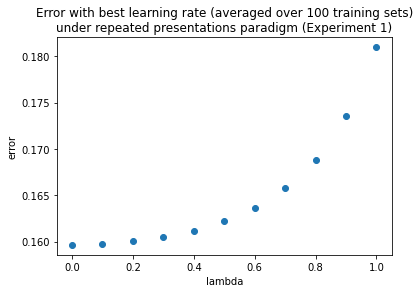

In [16]:
# Plot data points for Figure 3, Expt 1
plt.scatter(x = [elem[0] for elem in coords_Expt1],
            y = [elem[1] for elem in coords_Expt1])
plt.xlabel('lambda')
plt.ylabel('error')
plt.title('Error with best learning rate (averaged over 100 training sets)\nunder repeated presentations paradigm (Experiment 1)')
plt.savefig('./project1_expt1.png')
plt.show()

In [17]:
####### Experiment 2 - Version 1 ####### 

In [18]:
def TD_Lambda_Expt2(alpha=0.02,lambda_=0.2,verbose=False):

  '''
  Sutton's experiment 2. Single presentation of each training set. Weight vector updates after EACH sequence in a training set.
  
  Version 1: the sum of delta (w_t) persists across a training set and it is not reset to zero.
  
  Inputs:
  1. alpha: Learning rate
  2. lambda: discount factor
  3. verbose: whether you want printouts of the various intermediate variables (for debugging)
  '''
    
  global training_sets

  predictions = []
  w_vectors = []
  errors = []

  for training_set in training_sets:      # Present training set only ONCE

    # Sum of delta wt - accumulates the delta w_t in each state of sequence in training set
    sum_of_delta_wt = np.zeros(5)

    # Initialize w at the start of each training set
    # All components of weight vector initially set to 0.5, to avoid bias either toward right/left-side terminations
    w = np.array([0.5] * 5)

    for seq in training_set:

      if verbose:
        print("****SEQUENCE******",seq)
        print("Current value of w:",w)

      for t in range(len(seq)-1):

        if verbose:
          print("---State---",seq[t])

        gradients = ([list(x) for x in  seq[:t+1]])
        lambdas_ = [lambda_**exponent for exponent in range(0,t+1)]
        lambdas_.reverse()
        assert len(gradients) == len(lambdas_), print("Gradients {}, Lambdas {}".format(gradients,lambdas_))

        sum_of_gradients = [np.array(gradients[i]) * lambdas_[i] for i in range(len(gradients))]
        sum_of_gradients = np.array(sum_of_gradients).sum(axis=0)

        delta_wt = alpha * (P(w,seq[t+1]) - P(w,seq[t])) * sum_of_gradients
        sum_of_delta_wt = np.add(sum_of_delta_wt, delta_wt)

        if verbose:
          print("Gradients,Lambdas",gradients,lambdas_)
          print("Unweighted sum of gradients",np.array(gradients).sum(axis=0),"calculated from",seq[:t+1])
          print("Weighted sum of gradients",sum_of_gradients)
          print("Need to multiply [weighted] sum of gradients by alpha multiplied by difference between P calculated from {} (t+1) and P calculated from {} (t)".format(seq[t+1],seq[t]))
          print("P(t+1) = {}, P(t) = {}".format(P(w,seq[t+1]),P(w,seq[t]) ))
          print("Increment delta(w_t) = alpha * (difference between P) * (weighted sum of gradients) = ",delta_wt)

      # Weight update after each sequence, rather than after each complete training set
      w = w + sum_of_delta_wt
#       w = np.maximum(np.minimum(w,np.ones_like(w)), np.zeros_like(w)) # don't want negative weights
    
    # Save the weights at the end of each training set
    # w = np.maximum(w, np.zeros_like(w)) # don't want negative weights
    w_vectors.append(w)
    
    # Also save the predictions at the end of each training set
    pred = np.array([P(w,states[i]) for i in range(len(states))])
    pred = np.maximum(np.minimum(pred,np.ones_like(pred)),np.zeros_like(pred)) # you can't have negative probabilities
    predictions.append(pred)

    # Save error at end of each training set
    error = RMSError(pred=pred)
    errors.append(error)

  return np.array(errors).mean()

In [19]:
def optimize_TD_Lambda_Expt2(lambda_,alpha_min,alpha_max,num_alphas):
  '''
  Function for optimizing Expt 2 with grid search for alpha
  '''
  best_alpha = None
  best_error = np.inf
  for alpha in np.linspace(alpha_min,alpha_max,num_alphas):
    RMS = TD_Lambda_Expt2(lambda_ = lambda_, alpha = alpha)
    if RMS < best_error:
      best_error = RMS
      best_alpha = alpha
  return best_error,best_alpha

In [20]:
# Generate plot points for Expt 2 Version 1, Fig 5
coords_Expt2 = []
for lambda_ in np.linspace(0,1,10):
  best_error,_ = optimize_TD_Lambda_Expt2(lambda_ = lambda_,alpha_min = 0, alpha_max = 0.6, num_alphas = 100)
  datapoint = [lambda_,best_error]
  coords_Expt2.append(datapoint)

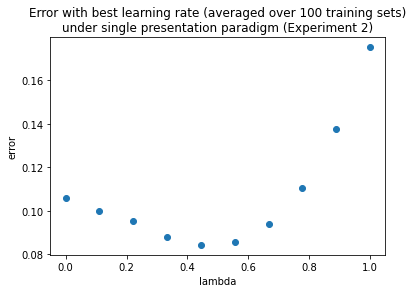

In [21]:
# Plot points for Expt 2 Version 1, Fig 5
plt.scatter(x = [elem[0] for elem in coords_Expt2],
            y = [elem[1] for elem in coords_Expt2])
plt.xlabel('lambda')
plt.ylabel('error')
plt.title('Error with best learning rate (averaged over 100 training sets)\nunder single presentation paradigm (Experiment 2)')
plt.savefig('./project1_expt2_Version1_Figure5.png')
plt.show()

In [22]:
def TD_Lambda_Expt2_Grid(lambdas_,alphas):
  data = {}
  for lambda_ in lambdas_:
    line = []
    for alpha in alphas:
      RMS = TD_Lambda_Expt2(lambda_ = lambda_, alpha = alpha)
      line.append([alpha,RMS])
    data[lambda_] = line
  return data

In [23]:
lambdas_ = [0,0.3,0.8,1]
alphas = np.linspace(0,0.6,6)

data = TD_Lambda_Expt2_Grid(lambdas_,alphas)

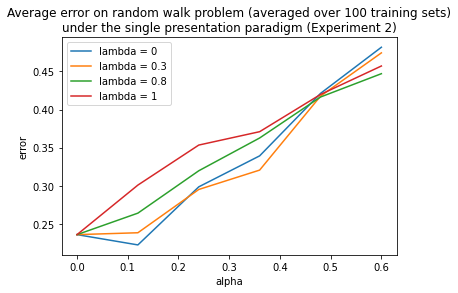

In [24]:
for key in data.keys():
  label = "lambda = " + str(key)
  line = data[key]
  x = [elem[0] for elem in line]
  y = [elem[1] for elem in line]
  plt.plot(x,y,label=label)
plt.legend()
plt.xlabel("alpha")
plt.ylabel("error")
plt.title("Average error on random walk problem (averaged over 100 training sets)\nunder the single presentation paradigm (Experiment 2)")
plt.savefig('./project1_expt2_Version1_Figure4.png')
plt.show()

In [25]:
####### Experiment 2 - Version 2 ####### 
# Experiment 2, but with resetting the accumulator of delta w_t (i.e. Sum of delta w_t) to zero in between sequences in the same training set

In [26]:
def TD_Lambda_Expt2_Version2(alpha=0.02,lambda_=0.2,verbose=False):

  global training_sets

  predictions = []
  w_vectors = []
  errors = []

  for training_set in training_sets:      # Present training set only ONCE

    # sum_of_delta_wt = np.zeros(5)

    # Initialize w at the start of each training set
    # All components of weight vector initially set to 0.5, to avoid bias either toward right/left-side terminations
    w = np.array([0.5] * 5)

    for seq in training_set:

      # Sum of delta_Wt will be reset at the end of each sequence
      sum_of_delta_wt = np.zeros(5)

      if verbose:
        print("****SEQUENCE******",seq)
        print("Current value of w:",w)

      for t in range(len(seq)-1):

        if verbose:
          print("---State---",seq[t])

        gradients = ([list(x) for x in  seq[:t+1]])
        lambdas_ = [lambda_**exponent for exponent in range(0,t+1)]
        lambdas_.reverse()
        assert len(gradients) == len(lambdas_), print("Gradients {}, Lambdas {}".format(gradients,lambdas_))

        sum_of_gradients = [np.array(gradients[i]) * lambdas_[i] for i in range(len(gradients))]
        sum_of_gradients = np.array(sum_of_gradients).sum(axis=0)

        delta_wt = alpha * (P(w,seq[t+1]) - P(w,seq[t])) * sum_of_gradients
        sum_of_delta_wt = np.add(sum_of_delta_wt, delta_wt)

        if verbose:
          print("Gradients,Lambdas",gradients,lambdas_)
          print("Unweighted sum of gradients",np.array(gradients).sum(axis=0),"calculated from",seq[:t+1])
          print("Weighted sum of gradients",sum_of_gradients)
          print("Need to multiply [weighted] sum of gradients by alpha multiplied by difference between P calculated from {} (t+1) and P calculated from {} (t)".format(seq[t+1],seq[t]))
          print("P(t+1) = {}, P(t) = {}".format(P(w,seq[t+1]),P(w,seq[t]) ))
          print("Increment delta(w_t) = alpha * (difference between P) * (weighted sum of gradients) = ",delta_wt)

      # Weight update after each sequence, rather than after each complete training set
      w = np.add(w,sum_of_delta_wt)
#       w = np.maximum(np.minimum(w,np.ones_like(w)), np.zeros_like(w)) ## don't want negative values in w
    
    # Save the (asymptotic) weights at the end of each training set
    # w = np.maximum(w, np.zeros_like(w)) # don't want negative weights
    w_vectors.append(w)
    
    # Also save the predictions at the end of each training set 
    pred = np.array([P(w,states[i]) for i in range(len(states))])
    pred = np.maximum(np.minimum(pred,np.ones_like(pred)),np.zeros_like(pred)) ## don't want negative prediction probabilities
    predictions.append(pred)

    # Save error (calculated using asymptotic weights) at the end of each training set
    error = RMSError(pred=np.array(pred))
    errors.append(error)

  return np.array(errors).mean()

In [27]:
def optimize_TD_Lambda_Expt2_Version2(lambda_,alpha_min,alpha_max,num_alphas):
  best_alpha = None
  best_error = np.inf
  best_pred = None
  true_val = (np.array(range(7))/6)[1:-1]
  for alpha in np.linspace(alpha_min,alpha_max,num_alphas):
    RMS = TD_Lambda_Expt2_Version2(lambda_ = lambda_, alpha = alpha)
    if RMS < best_error:
      best_error = RMS
      best_alpha = alpha
  return best_error,best_alpha

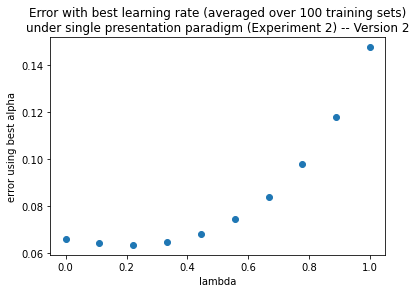

In [28]:
coords = []
for lambda_ in np.linspace(0,1,10):
  best_error,_ = optimize_TD_Lambda_Expt2_Version2(lambda_ = lambda_,alpha_min = 0, alpha_max = 0.6, num_alphas = 100)
  datapoint = [lambda_,best_error]
  coords.append(datapoint)

plt.scatter(x = [elem[0] for elem in coords],
            y = [elem[1] for elem in coords])
plt.xlabel('lambda')
plt.ylabel('error using best alpha')
plt.title('Error with best learning rate (averaged over 100 training sets)\nunder single presentation paradigm (Experiment 2) -- Version 2')
plt.savefig('./project1_expt2_Version2_Figure5.png')
plt.show()

In [29]:
def TD_Lambda_Expt2_Version2_Grid(lambdas_,alphas):
  data = {}
  for lambda_ in lambdas_:
    line = []
    for alpha in alphas:
      RMS = TD_Lambda_Expt2_Version2(lambda_ = lambda_, alpha = alpha)
      line.append([alpha,RMS])
    data[lambda_] = line
  return data

In [30]:
lambdas_ = [0,0.3,0.8,1]
alphas = [0,0.1,0.2,0.3,0.4,0.5,0.6]

data = TD_Lambda_Expt2_Grid(lambdas_,alphas)

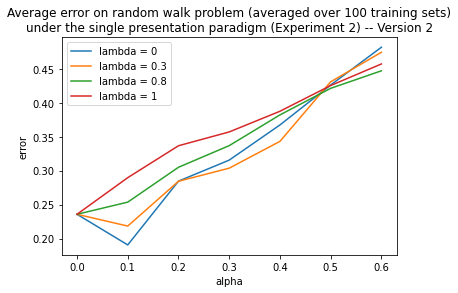

In [31]:
for key in data.keys():
  label = "lambda = " + str(key)
  line = data[key]
  x = [elem[0] for elem in line]
  y = [elem[1] for elem in line]
  plt.plot(x,y,label=label)
plt.legend()
plt.xlabel("alpha")
plt.ylabel("error")
plt.title("Average error on random walk problem (averaged over 100 training sets)\nunder the single presentation paradigm (Experiment 2) -- Version 2")
plt.savefig('./project1_expt2_Version2_Figure4.png')
plt.show()

In [33]:
#################################################################
#################################################################
##########################PART B#################################
############## EXPERIMENTS 1 AND 2, WITHOUT REMOVING PROBABILITY PREDICTIONS THAT ARE NEGATIVE OR LARGER THAN UNITY ##############
#################################################################
#################################################################
#################################################################

C:\Users\ansel\AppData\Local\Temp/ipykernel_1384/4089557768.py:66: RuntimeWarning: overflow encountered in add
  sum_of_delta_wt = np.add(sum_of_delta_wt, delta_wt)
C:\Users\ansel\AppData\Local\Temp/ipykernel_1384/4089557768.py:65: RuntimeWarning: overflow encountered in double_scalars
  delta_wt = alpha * (P(w,seq[t+1]) - P(w,seq[t])) * weighted_sum_of_gradients
C:\Users\ansel\AppData\Local\Temp/ipykernel_1384/4089557768.py:65: RuntimeWarning: invalid value encountered in multiply
  delta_wt = alpha * (P(w,seq[t+1]) - P(w,seq[t])) * weighted_sum_of_gradients


[0.0, 0.15964493512006764]


C:\Users\ansel\AppData\Local\Temp/ipykernel_1384/4089557768.py:66: RuntimeWarning: invalid value encountered in add
  sum_of_delta_wt = np.add(sum_of_delta_wt, delta_wt)


[0.1, 0.15975551958864698]
[0.2, 0.16003543574159707]
[0.30000000000000004, 0.16050167647280744]
[0.4, 0.1611953981213126]
[0.5, 0.16219697326329086]
[0.6000000000000001, 0.16363609708337198]
[0.7000000000000001, 0.16573496078334615]
[0.8, 0.16885546668862886]
[0.9, 0.17359342575282372]
[1.0, 0.18096167181330652]


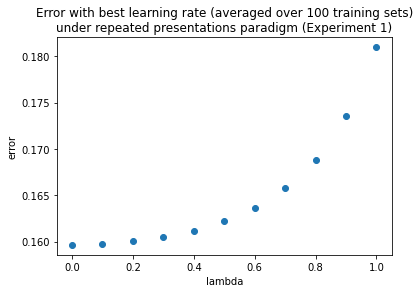

In [35]:
################################
################################
######### Experiment 1 #########
################################
################################

# An exception class to be raised when there is "nonconvergence" beyond a certain number of presentations of the training set
class NonconvergenceException(BaseException):
  def __init__(self):
    super().__init__()

def TD_Lambda_Expt1(alpha=0.02,lambda_=0.2,verbose=False,max_presentations = 1000):
  
  '''
  Sutton's experiment 1, where there are multiple presentations of training set until convergence, and weight vector is only updated at the end of each training set presentation
  
  Inputs:
  1. alpha: Learning rate
  2. lambda: discount factor
  3. verbose: whether you want printouts of the various intermediate variables (for debugging)
  4. max_presentations: a limit on the number of presentations a training set can be presented before a NonconvergenceException is raised
  '''

  global training_sets 

  predictions = []                    # Array of predictions across training sets
  errors = []                         # Array of errors across training sets
  w_vectors = []                      # Array of weight vectors across training sets

  for training_set in training_sets:  # For each training set in the collection of 100 training sets

    # Initialize w at the start of each training set
    w = np.random.uniform(0,1,5)      # Final weight vector is independent of the initialization

    is_not_converged = True
    num_presentations = 0             

    while is_not_converged:           # Present each training set multiple times until convergence of weight vector
    
      # To prevent issues with running time if there is nonconvergence due to large alpha.
      if num_presentations > max_presentations:
        break

      # We will accumulate the delta w_t's across sequences in a presentation of a training set
      sum_of_delta_wt = np.zeros(5)   # Initialize accumulator of delta w_t's to zero at the start of each presentation

      for seq in training_set:        # For each of the 10 sequences in the training set

        if verbose:
          print("****SEQUENCE******",seq)
          print("Current value of w:",w)

        for t in range(len(seq)-1):   # For each of the m states in the sequence

          if verbose:
            print("---State---",seq[t])

          # Calculate weighted sum of gradients
          gradients = ([list(x) for x in seq[:t+1]])
          lambdas_ = [lambda_**exponent for exponent in range(0,t+1)]
          lambdas_.reverse()
          weighted_gradients = [np.array(gradients[i]) * lambdas_[i] for i in range(len(gradients))]
          weighted_sum_of_gradients = np.array(weighted_gradients).sum(axis=0)

          delta_wt = alpha * (P(w,seq[t+1]) - P(w,seq[t])) * weighted_sum_of_gradients
          sum_of_delta_wt = np.add(sum_of_delta_wt, delta_wt)

          if verbose:
            print("Gradients (x_t),Lambdas (exponential weighting)",gradients,lambdas_)
            print("Unweighted sum of gradients (sum of x_t) =",np.array(gradients).sum(axis=0),"was calculated from",seq[:t+1])
            print("Weighted sum of gradients (weighted sum of x_t)",weighted_sum_of_gradients)
            print("Need to multiply [weighted] sum of gradients by alpha multiplied by difference between P calculated from {} (t+1) and P calculated from {} (t)".format(seq[t+1],seq[t]))
            print("P(t+1) = {}, P(t) = {}".format(P(w,seq[t+1]),P(w,seq[t]) ))
            print("Increment delta(w_t) = alpha * (difference between P) * (weighted sum of gradients) = ",delta_wt)
            print("Sum of delta_wt",sum_of_delta_wt)

      # Update the weight vector only after each complete presentation of the training set
      w_new = np.add(w, sum_of_delta_wt)
      if np.isclose(w_new,w).all():
        is_not_converged = False
        w = w_new
      else:
        num_presentations += 1
        w = w_new
    
    if is_not_converged:
      raise NonconvergenceException
    
    # Save the weights at the end of each training set
    w_vectors.append(w)

    # Also save the predictions at the end of each training set
    pred = np.array([P(w,states[i]) for i in range(len(states))])
#     pred = np.maximum(np.minimum(pred,np.ones_like(pred)),np.zeros_like(pred))
    error = RMSError(pred = np.array(pred))
    predictions.append(pred)

    # Save the error of that training set
    errors.append(error)

  return np.array(errors).mean()

# Try out Experimnent 1 with default settings of alpha and lambda
TD_Lambda_Expt1(alpha=0.02,lambda_=0.2,
                # verbose=True, 
                max_presentations = 1000)

def optimize_TD_Lambda_Expt1(lambda_,alpha_min,alpha_max,num_alphas,max_presentations):
  '''
  A function for optimizing TD(lambda) under Experiment 1 regime, with a grid search for the best alpha which gives the best RMSE error.
  The user has to input the minimum alpha, max alpha, and the number of alphas he wants to search over.
  The user is also able to enter the number of max presentations that will be allowed.
  '''
  best_alpha = None
  best_error = np.inf
  for alpha in np.linspace(alpha_min,alpha_max,num_alphas): 
    try:
      RMSE =  TD_Lambda_Expt1(lambda_ = lambda_, alpha=alpha, max_presentations = max_presentations)
    except NonconvergenceException:
      continue
    if RMSE < best_error:
      best_error = RMSE
      best_alpha = alpha
  return best_error,best_alpha

# Generate datapoints for Figure 3, Expt 1
coords_Expt1 = []
for lambda_ in np.linspace(0,1,11):
  best_error,_ = optimize_TD_Lambda_Expt1(lambda_ = lambda_,alpha_min = 0, alpha_max = 0.3, num_alphas = 30,max_presentations = 1000)
  datapoint = [lambda_,best_error]
  print(datapoint)
  coords_Expt1.append(datapoint)

# Plot data points for Figure 3, Expt 1
plt.scatter(x = [elem[0] for elem in coords_Expt1],
            y = [elem[1] for elem in coords_Expt1])
plt.xlabel('lambda')
plt.ylabel('error')
plt.title('Error with best learning rate (averaged over 100 training sets)\nunder repeated presentations paradigm (Experiment 1)')
plt.savefig('./project1_expt1.png')
plt.show()

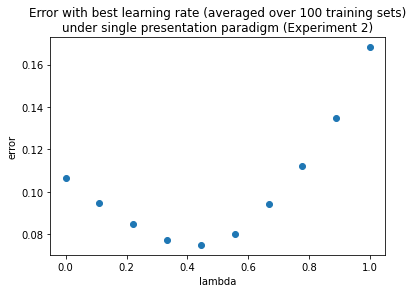

In [36]:

####### Experiment 2 - Version 1 ####### 

def TD_Lambda_Expt2(alpha=0.02,lambda_=0.2,verbose=False):

  '''
  Sutton's experiment 2. Single presentation of each training set. Weight vector updates after EACH sequence in a training set.
  
  Version 1: the sum of delta (w_t) persists across a training set and it is not reset to zero.
  
  Inputs:
  1. alpha: Learning rate
  2. lambda: discount factor
  3. verbose: whether you want printouts of the various intermediate variables (for debugging)
  '''
    
  global training_sets

  predictions = []
  w_vectors = []
  errors = []

  for training_set in training_sets:      # Present training set only ONCE

    # Sum of delta wt - accumulates the delta w_t in each state of sequence in training set
    sum_of_delta_wt = np.zeros(5)

    # Initialize w at the start of each training set
    # All components of weight vector initially set to 0.5, to avoid bias either toward right/left-side terminations
    w = np.array([0.5] * 5)

    for seq in training_set:

      if verbose:
        print("****SEQUENCE******",seq)
        print("Current value of w:",w)

      for t in range(len(seq)-1):

        if verbose:
          print("---State---",seq[t])

        gradients = ([list(x) for x in  seq[:t+1]])
        lambdas_ = [lambda_**exponent for exponent in range(0,t+1)]
        lambdas_.reverse()
        assert len(gradients) == len(lambdas_), print("Gradients {}, Lambdas {}".format(gradients,lambdas_))

        sum_of_gradients = [np.array(gradients[i]) * lambdas_[i] for i in range(len(gradients))]
        sum_of_gradients = np.array(sum_of_gradients).sum(axis=0)

        delta_wt = alpha * (P(w,seq[t+1]) - P(w,seq[t])) * sum_of_gradients
        sum_of_delta_wt = np.add(sum_of_delta_wt, delta_wt)

        if verbose:
          print("Gradients,Lambdas",gradients,lambdas_)
          print("Unweighted sum of gradients",np.array(gradients).sum(axis=0),"calculated from",seq[:t+1])
          print("Weighted sum of gradients",sum_of_gradients)
          print("Need to multiply [weighted] sum of gradients by alpha multiplied by difference between P calculated from {} (t+1) and P calculated from {} (t)".format(seq[t+1],seq[t]))
          print("P(t+1) = {}, P(t) = {}".format(P(w,seq[t+1]),P(w,seq[t]) ))
          print("Increment delta(w_t) = alpha * (difference between P) * (weighted sum of gradients) = ",delta_wt)

      # Weight update after each sequence, rather than after each complete training set
      w = w + sum_of_delta_wt
#       w = np.maximum(np.minimum(w,np.ones_like(w)), np.zeros_like(w)) # don't want negative weights
    
    # Save the weights at the end of each training set
    # w = np.maximum(w, np.zeros_like(w)) # don't want negative weights
    w_vectors.append(w)
    
    # Also save the predictions at the end of each training set
    pred = np.array([P(w,states[i]) for i in range(len(states))])
#     pred = np.maximum(np.minimum(pred,np.ones_like(pred)),np.zeros_like(pred)) # you can't have negative probabilities
    predictions.append(pred)

    # Save error at end of each training set
    error = RMSError(pred=pred)
    errors.append(error)

  return np.array(errors).mean()

def optimize_TD_Lambda_Expt2(lambda_,alpha_min,alpha_max,num_alphas):
  '''
  Function for optimizing Expt 2 with grid search for alpha
  '''
  best_alpha = None
  best_error = np.inf
  for alpha in np.linspace(alpha_min,alpha_max,num_alphas):
    RMS = TD_Lambda_Expt2(lambda_ = lambda_, alpha = alpha)
    if RMS < best_error:
      best_error = RMS
      best_alpha = alpha
  return best_error,best_alpha

# Generate plot points for Expt 2 Version 1, Fig 5
coords_Expt2 = []
for lambda_ in np.linspace(0,1,10):
  best_error,_ = optimize_TD_Lambda_Expt2(lambda_ = lambda_,alpha_min = 0, alpha_max = 0.6, num_alphas = 100)
  datapoint = [lambda_,best_error]
  coords_Expt2.append(datapoint)

# Plot points for Expt 2 Version 1, Fig 5
plt.scatter(x = [elem[0] for elem in coords_Expt2],
            y = [elem[1] for elem in coords_Expt2])
plt.xlabel('lambda')
plt.ylabel('error')
plt.title('Error with best learning rate (averaged over 100 training sets)\nunder single presentation paradigm (Experiment 2)')
plt.savefig('./project1_expt2_Version1_Figure5.png')
plt.show()

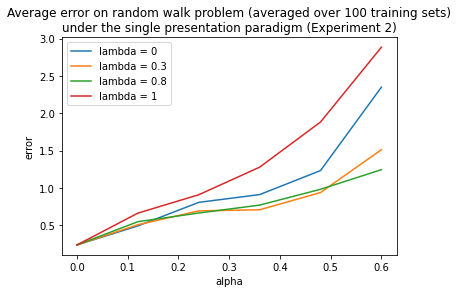

In [37]:
def TD_Lambda_Expt2_Grid(lambdas_,alphas):
  data = {}
  for lambda_ in lambdas_:
    line = []
    for alpha in alphas:
      RMS = TD_Lambda_Expt2(lambda_ = lambda_, alpha = alpha)
      line.append([alpha,RMS])
    data[lambda_] = line
  return data

lambdas_ = [0,0.3,0.8,1]
alphas = np.linspace(0,0.6,6)

data = TD_Lambda_Expt2_Grid(lambdas_,alphas)

for key in data.keys():
  label = "lambda = " + str(key)
  line = data[key]
  x = [elem[0] for elem in line]
  y = [elem[1] for elem in line]
  plt.plot(x,y,label=label)
plt.legend()
plt.xlabel("alpha")
plt.ylabel("error")
plt.title("Average error on random walk problem (averaged over 100 training sets)\nunder the single presentation paradigm (Experiment 2)")
plt.savefig('./project1_expt2_Version1_Figure4.png')
plt.show()

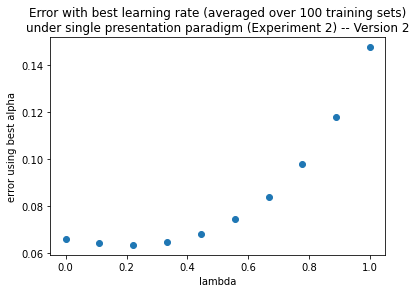

In [38]:
####### Experiment 2 - Version 2 ####### 
# Experiment 2, but with resetting the accumulator of delta w_t (i.e. Sum of delta w_t) to zero in between sequences in the same training set

def TD_Lambda_Expt2_Version2(alpha=0.02,lambda_=0.2,verbose=False):

  global training_sets

  predictions = []
  w_vectors = []
  errors = []

  for training_set in training_sets:      # Present training set only ONCE

    # sum_of_delta_wt = np.zeros(5)

    # Initialize w at the start of each training set
    # All components of weight vector initially set to 0.5, to avoid bias either toward right/left-side terminations
    w = np.array([0.5] * 5)

    for seq in training_set:

      # Sum of delta_Wt will be reset at the end of each sequence
      sum_of_delta_wt = np.zeros(5)

      if verbose:
        print("****SEQUENCE******",seq)
        print("Current value of w:",w)

      for t in range(len(seq)-1):

        if verbose:
          print("---State---",seq[t])

        gradients = ([list(x) for x in  seq[:t+1]])
        lambdas_ = [lambda_**exponent for exponent in range(0,t+1)]
        lambdas_.reverse()
        assert len(gradients) == len(lambdas_), print("Gradients {}, Lambdas {}".format(gradients,lambdas_))

        sum_of_gradients = [np.array(gradients[i]) * lambdas_[i] for i in range(len(gradients))]
        sum_of_gradients = np.array(sum_of_gradients).sum(axis=0)

        delta_wt = alpha * (P(w,seq[t+1]) - P(w,seq[t])) * sum_of_gradients
        sum_of_delta_wt = np.add(sum_of_delta_wt, delta_wt)

        if verbose:
          print("Gradients,Lambdas",gradients,lambdas_)
          print("Unweighted sum of gradients",np.array(gradients).sum(axis=0),"calculated from",seq[:t+1])
          print("Weighted sum of gradients",sum_of_gradients)
          print("Need to multiply [weighted] sum of gradients by alpha multiplied by difference between P calculated from {} (t+1) and P calculated from {} (t)".format(seq[t+1],seq[t]))
          print("P(t+1) = {}, P(t) = {}".format(P(w,seq[t+1]),P(w,seq[t]) ))
          print("Increment delta(w_t) = alpha * (difference between P) * (weighted sum of gradients) = ",delta_wt)

      # Weight update after each sequence, rather than after each complete training set
      w = np.add(w,sum_of_delta_wt)
#       w = np.maximum(np.minimum(w,np.ones_like(w)), np.zeros_like(w)) ## don't want negative values in w
    
    # Save the (asymptotic) weights at the end of each training set
    # w = np.maximum(w, np.zeros_like(w)) # don't want negative weights
    w_vectors.append(w)
    
    # Also save the predictions at the end of each training set 
    pred = np.array([P(w,states[i]) for i in range(len(states))])
#     pred = np.maximum(np.minimum(pred,np.ones_like(pred)),np.zeros_like(pred)) ## don't want negative prediction probabilities
    predictions.append(pred)

    # Save error (calculated using asymptotic weights) at the end of each training set
    error = RMSError(pred=np.array(pred))
    errors.append(error)

  return np.array(errors).mean()

def optimize_TD_Lambda_Expt2_Version2(lambda_,alpha_min,alpha_max,num_alphas):
  best_alpha = None
  best_error = np.inf
  best_pred = None
  true_val = (np.array(range(7))/6)[1:-1]
  for alpha in np.linspace(alpha_min,alpha_max,num_alphas):
    RMS = TD_Lambda_Expt2_Version2(lambda_ = lambda_, alpha = alpha)
    if RMS < best_error:
      best_error = RMS
      best_alpha = alpha
  return best_error,best_alpha

coords = []
for lambda_ in np.linspace(0,1,10):
  best_error,_ = optimize_TD_Lambda_Expt2_Version2(lambda_ = lambda_,alpha_min = 0, alpha_max = 0.6, num_alphas = 100)
  datapoint = [lambda_,best_error]
  coords.append(datapoint)

plt.scatter(x = [elem[0] for elem in coords],
            y = [elem[1] for elem in coords])
plt.xlabel('lambda')
plt.ylabel('error using best alpha')
plt.title('Error with best learning rate (averaged over 100 training sets)\nunder single presentation paradigm (Experiment 2) -- Version 2')
plt.savefig('./project1_expt2_Version2_Figure5.png')
plt.show()

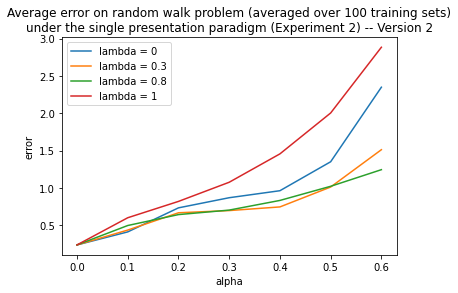

In [39]:

def TD_Lambda_Expt2_Version2_Grid(lambdas_,alphas):
  data = {}
  for lambda_ in lambdas_:
    line = []
    for alpha in alphas:
      RMS = TD_Lambda_Expt2_Version2(lambda_ = lambda_, alpha = alpha)
      line.append([alpha,RMS])
    data[lambda_] = line
  return data

lambdas_ = [0,0.3,0.8,1]
alphas = [0,0.1,0.2,0.3,0.4,0.5,0.6]

data = TD_Lambda_Expt2_Grid(lambdas_,alphas)

for key in data.keys():
  label = "lambda = " + str(key)
  line = data[key]
  x = [elem[0] for elem in line]
  y = [elem[1] for elem in line]
  plt.plot(x,y,label=label)
plt.legend()
plt.xlabel("alpha")
plt.ylabel("error")
plt.title("Average error on random walk problem (averaged over 100 training sets)\nunder the single presentation paradigm (Experiment 2) -- Version 2")
plt.savefig('./project1_expt2_Version2_Figure4.png')
plt.show()